## Notebook: Parole Hearings - Commiting Errors When Analyzing Sensible Data

Parole hearing in the state of New York

The focus of this dataset is to study fairness according to perp location.

Some questions we can raise over this dataset:

- It is possible to predict the parole commissioner decision ?
- Which features are most important to define the sentence of a criminal ?
- What the correlation graph can tell about the features ?
- Joining different datasets, we can better understand the sentences ?
- Where most crimes happen ?
- Are in poor or rich counties ?

Datasets link: https://www.kaggle.com/parole-hearing-data/parole-hearings-in-new-york-state

### Dataset Dictionary

Here we will specify only the non-intutive features

- DIN: is assigned to each offender admitted to the Department of Correctional Services. This is an internal number used as an identifier for the offender while he or she is in the custody of the Department.
- Housing or Interview Facility: This shows the Correctional Facility where the offender is being housed before his/her Board appearance. Interview facility shows the place where the interview was held. 
- Housing/Release facility: is the place where the offender was released from.
- Release Type: This is the circumstance under which the offender is released from a Correctional Facility.
- Release Date: The date an offender is released from a Correctional Facility prior to the maximum expiration date.
- Parole eligibility Date: Under certain circumstances, an offender may be released prior to serving his or her minimum term. 
- Aggregated Minimum / Maximum Sentence: These fields contain an aggregate of the amount of time the offender must serve for the crimes for which he or she was committed. (year months - year months)
- Maximum Expiration Date: If an offender is not released by the Parole Board or by conditional release, he or she will remain in custody until his or her maximum expiration date. The offender's sentence is deemed completed as of this date.
- Post Release Supervision me Date: ndicates how long the offender may be under post release supervision.
- Parole Board Discharge Date: This indicates the offender has been discharged from parole supervision before the maximum expiration date or the maximum expiration date for parole supervision.
- Parole Interview Type: This indicates the type of the next appearance by the offender before the Parole Board. It may be his or her initial appearance, reappearance, or a variety of other hearing types.
- Parole Me Date: ??


Taken from: http://www.doccs.ny.gov/calendardatadefinitions.html



### Evaluated Boroughs

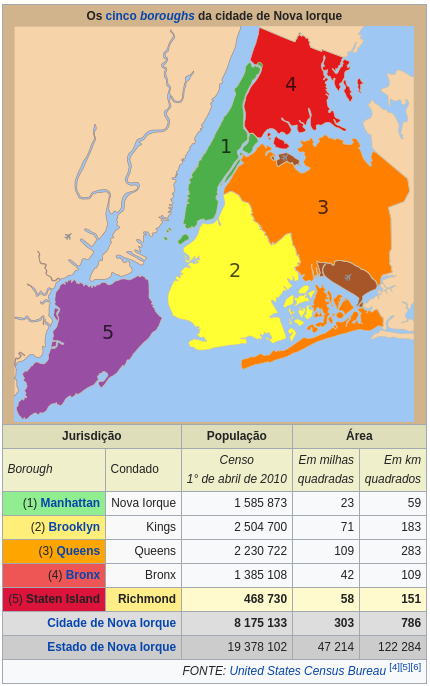

In [7]:
from IPython.display import Image
Image("Aux/evaluated_boroughs.png")

In [101]:
import datetime
import re
import time

import seaborn as sns
import statistics

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [102]:
df = pd.read_table("Input/data.csv", sep = ',', low_memory = False)

### Removing invalid rows

The remove rows do not aggregate much for our analyzes, given that it not contain must of the features.

In [103]:
df = df.loc[
        (df['parole board interview date'] != '*') & 
        (df['interview decision'] != '*') &
        (df['interview decision'] != '**********') &
        (df['birth date'] != 'UNKNOWN') &
        (df['conditional release date'] != 'NONE') &
        (df['maximum expiration date'] != 'LIFE SENTENCE')
        ]

### Auxiliary Function: Count Instances

Count amount of each instances type

In [104]:
def count_instances(df, feature):
    keys = set(df[feature])
    values = {}
    for key in keys:
        values[key] = len(df[df[feature] == key])
    
    return values

### Auxiliary Function: Count NaN

In [105]:
def count_nan(df):
    for col in df.columns:
        if df[col].isna().values.any():
            print(col, df[col].isna().sum(), round(df[col].isna().sum()/len(df), 5))
# count_nan(df)

### Parsing Date 

In [106]:
date, token = [], 'parole board interview date'
for _, instance in df.iterrows():
    date.append('-'.join(instance[token].split('-')[:2]))
df[token] = date

### Auxiliary Function: Standard Timestamp Values

In [107]:
def standard_tv(df, columns):

    for column in columns:
        try:
            df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
        except:
            df[column] = pd.to_datetime(df[column], format='%Y-%m')

    return df

date_columns = list(filter(lambda x: 'date' in x, df.columns))
standard_tv(df, date_columns)

,parole board interview date,din,scrape date,nysid,sex,birth date,race / ethnicity,housing or interview facility,parole board interview type,interview decision,...,crime 5 - county of commitment,crime 6 - crime of conviction,crime 6 - class,crime 6 - county of commitment,crime 7 - crime of conviction,crime 7 - class,crime 7 - county of commitment,crime 8 - crime of conviction,crime 8 - class,crime 8 - county of commitment
660,2012-08-01,03B2727,2014-08-05,08868271Z,MALE,1981-06-07,BLACK,LIVINGSTON,INITIAL,DENIED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,2012-08-01,04A5142,2014-08-05,04919051Z,MALE,2056-03-28,BLACK,LIVINGSTON,INITIAL,DENIED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662,2012-08-01,05B0786,2014-08-05,04281357Q,MALE,2059-04-19,WHITE,LIVINGSTON,REAPPEAR,DENIED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663,2012-08-01,09B2160,2014-08-05,08883878R,MALE,1981-07-16,BLACK,LIVINGSTON,REAPPEAR,DENIED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
664,2012-08-01,10A0062,2014-08-05,05705635M,MALE,1971-02-16,BLACK,ADIRONDACK,INITIAL,DENIED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,2012-08-01,10A3408,2014-08-05,06737683P,MALE,2058-08-02,HISPANIC,LIVINGSTON,ECPDO,GRANTED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,2012-08-01,10B0930,2014-08-05,06750206L,MALE,1974-09-16,BLACK,LIVINGSTON,MERIT TIME,OR EARLIER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,2012-08-01,10B2999,2014-08-05,02984681Q,MALE,1982-12-15,BLACK,LIVINGSTON,INITIAL,DENIED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,2012-08-01,10B3660,2014-08-05,08753623Y,MALE,1981-08-30,WHITE,LIVINGSTON,INITIAL,DENIED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,2012-08-01,10R1708,2014-08-05,01215031K,MALE,1987-02-28,BLACK,MT. MCGREGOR,MERIT TIME,NOT GRANTD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Auxiliary Function: Converting pandas timestamps to seconds

In [108]:
def convert_to_seconds(value):

    if value is pd.NaT:
        return 0

    t = value.to_pydatetime()

    return time.mktime(t.timetuple())

### Evaluating timestamps: Removing NaN values - It's possible to fill the NaN timestamp values ? 

It is not possible. The distributions of time are much different.

In [109]:
date_columns = list(filter(lambda x: 'date' in x, df.columns))

df_complete_date = df.dropna(axis=0, subset=date_columns)
for column in date_columns:
    values = list(map(lambda x: convert_to_seconds(x), df[column]))
    df[column] = values

Considering all the features, we have to evaluate what date features will help the classifier to better predict. Some date attributes will not imply on the distribution of the other features, as Birth Date, other features will be removed, as scrape date. The main features for us are parole related. Bellow we try to make a timeline of events, considering what happens, example: Jail -> Parole Me Date -> ... -> Release Date

Will not be considered for the prediction: Release Date, cause represent when the criminal was released.

### Evaluate the correlation between date features

Correlation between the features are very low

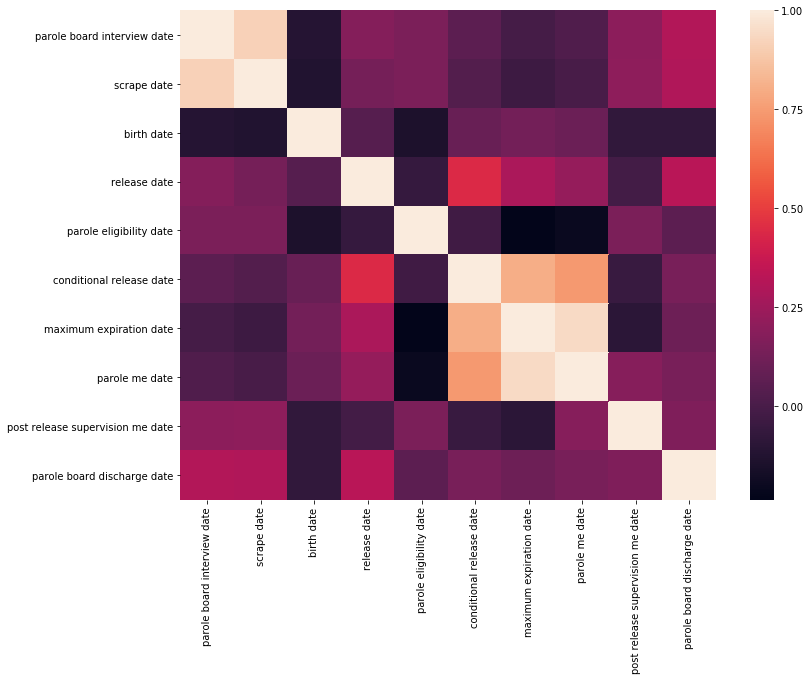

In [110]:
df_dates = df_complete_date.drop(list(filter(lambda x: 'date' not in x,
                                  df.columns)), axis = 1)

for column in date_columns:
    values = list(map(lambda x: convert_to_seconds(x), df_dates[column]))
    df_dates[column] = values
df_corr = df_dates.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(df_corr, xticklabels = df_dates.columns, yticklabels = df_dates.columns, linewidths=0)

### Plotting Time Evaluations

In [111]:
def make_graph(df, columns):
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    y =  [i for i in range(0, len(df[columns[0]]))]
    for column in columns:
        ax.plot_date(x=list(df[column]), y=y, marker='o', alpha = 1)

    plt.title("Fields DateTime Distribution")
    plt.xlabel("Datetime")
    plt.ylabel("Num. Values")
    plt.grid(True)
    plt.legend(columns)
    plt.show()

### Distribution of Time Fields Without Considering Nan Values

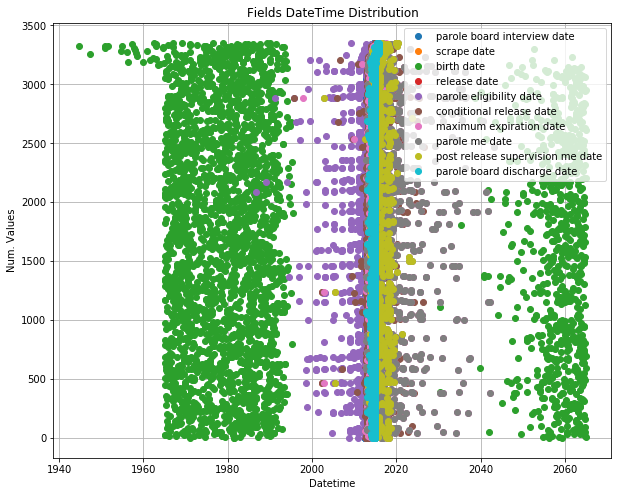

In [112]:
date_columns = list(filter(lambda x: 'date' in x, df_complete_date.columns))
make_graph(df_complete_date, date_columns)

### Pre-Processing: Removing Useless Rows and Columns

In [113]:
# pd.set_option('display.max_columns', 500)
# removing columns with useless informartion or with many NaN values

crimes = ['crime 5 - crime of conviction', 'crime 5 - class',
          'crime 5 - county of commitment']

df = df.drop(['year of entry', 'scrape date', 'din', 'nysid'] + crimes,  axis=1)
# removing instances with NaN values
columns_instances = ['aggregated minimum sentence', 'aggregated maximum sentence']
df.dropna(axis=0, subset=columns_instances, inplace=True)
for feature in columns_instances:
    df = df[df[feature].str.contains("-")]

### New Field: Number of Commited Crimes

Aggregating the crimes commited.

In [114]:
crimes_columns = [feature for feature in df.columns if 'crime of conviction' in feature]
crime_counter = []
for _, instance in df.iterrows():
    crime_counter.append(len(list(filter(lambda x: isinstance(instance.loc[x], str), crimes_columns))))

df['Number of Crimes'] = crime_counter

### Selecting only Perps that at least only crime was within New York City 

In [115]:
boroughs = ['NEW YORK', 'KINGS', 'QUEENS', 'BRONX', 'RICHMOND']
df = df.loc[(df['crime 1 - county of commitment'].isin(boroughs))]

### Parsing Aggregated Minimum / Maximum sentence

- Making new columns: Min. / Max. Sentence Month, Min. / Max. Sentence Years

In [116]:
token_min = 'aggregated minimum sentence'
token_max = 'aggregated maximum sentence'
year_max, year_min, month_max, month_min = [], [], [], []
invalid_rows = []

for index, instance in df.iterrows():

    year_max.append(instance[token_max].split('-')[0])
    month_max.append(instance[token_max].split('-')[1])

    year_min.append(instance[token_min].split('-')[0])
    month_min.append(instance[token_min].split('-')[1])

    
df['Max Sentence Month'] = month_max
df['Max Sentence Year'] = year_max

df['Min Sentence Month'] = month_min
df['Min Sentence Year'] = year_min

df.drop([token_min, token_max], axis=1)

,parole board interview date,sex,birth date,race / ethnicity,housing or interview facility,parole board interview type,interview decision,release date,release type,housing/release facility,...,crime 7 - class,crime 7 - county of commitment,crime 8 - crime of conviction,crime 8 - class,crime 8 - county of commitment,Number of Crimes,Max Sentence Month,Max Sentence Year,Min Sentence Month,Min Sentence Year
664,1.343790e+09,MALE,3.552120e+07,BLACK,ADIRONDACK,INITIAL,DENIED,1.389751e+09,CR,QUEENSBORO,...,NaN,NaN,NaN,NaN,NaN,3,00,07,06,03
666,1.343790e+09,MALE,2.795483e+09,HISPANIC,LIVINGSTON,ECPDO,GRANTED,1.346209e+09,BOARD,ORLEANS,...,NaN,NaN,NaN,NaN,NaN,2,00,05,00,00
670,1.343790e+09,MALE,5.414796e+08,BLACK,MT. MCGREGOR,MERIT TIME,NOT GRANTD,1.366686e+09,BOARD,MT. MCGREGOR,...,NaN,NaN,NaN,NaN,NaN,1,00,05,06,02
671,1.343790e+09,MALE,2.675041e+09,WHITE,MT. MCGREGOR,MERIT TIME,NOT GRANTD,1.366340e+09,BOARD,MT. MCGREGOR,...,NaN,NaN,NaN,NaN,NaN,4,07,06,06,02
672,1.343790e+09,MALE,2.993857e+09,BLACK,ADIRONDACK,INITIAL,DENIED,1.363576e+09,CR,QUEENSBORO,...,NaN,NaN,NaN,NaN,NaN,1,00,03,06,01
673,1.343790e+09,MALE,2.986092e+08,HISPANIC,ADIRONDACK,MERIT TIME,NOT GRANTD,1.366168e+09,CR,ADIRONDACK,...,NaN,NaN,NaN,NaN,NaN,2,00,03,06,02
675,1.343790e+09,MALE,-1.206900e+08,BLACK,LIVINGSTON,INITIAL,DENIED,1.373598e+09,CR,LIVINGSTON,...,NaN,NaN,NaN,NaN,NaN,1,00,04,00,02
676,1.343790e+09,MALE,-7.178760e+07,HISPANIC,WALLKILL,INITIAL,DENIED,1.373857e+09,CR,WALLKILL,...,NaN,NaN,NaN,NaN,NaN,2,00,04,00,02
678,1.343790e+09,MALE,2.760588e+08,HISPANIC,ADIRONDACK,SUPP MERIT,OR EARLIER,1.421114e+09,NaN,QUEENSBORO,...,NaN,NaN,NaN,NaN,NaN,1,00,04,00,02
692,1.343790e+09,MALE,2.857604e+09,BLACK,LIVINGSTON,INITIAL,DENIED,1.377572e+09,CR,QUEENSBORO,...,NaN,NaN,NaN,NaN,NaN,1,00,05,06,02


### Tasks:
    - Remove all NaN values (mainly from crimes features)
    - Remove category features and pass all for number

In [117]:
count_instances(df, 'interview decision') # define each one of these classes and group equal values

{'GRANTED': 133,
 'REINSTATE': 3,
 'OPEN DATE': 2010,
 'RCND&RELSE;': 12,
 'DENIED': 6629,
 'NOT GRANTD': 1105,
 'OR EARLIER': 2460,
 'PAROLED': 39,
 'RCND&HOLD;': 4}

### Filling NaN from crime features

In [118]:
crime_columns = list(filter(lambda x: 'crime' in x, df.columns))
for column in crime_columns:
    df[column].fillna('Not Commited', inplace = True)

### Removing Special Characteres and Number of Crimes

In [119]:
commited_crimes = list(filter(lambda x: 'crime of conviction' in x, df.columns))

crimes = {'IDENTITY THEFT': 'IDENT THEFT', 'STALKINGST': 'STALKING'}
for column in commited_crimes:
    df[column] = list(map(lambda x: re.sub(r'[ ]*[^A-z ]+', '', x), df[column]))
    df[column] = df[column].replace(crimes)

# Research Question: Where most crimes happen ? Are this related with some index of the other base ?

Text(0.5, 1.0, 'Number of Commited Crimes per County in New York City')

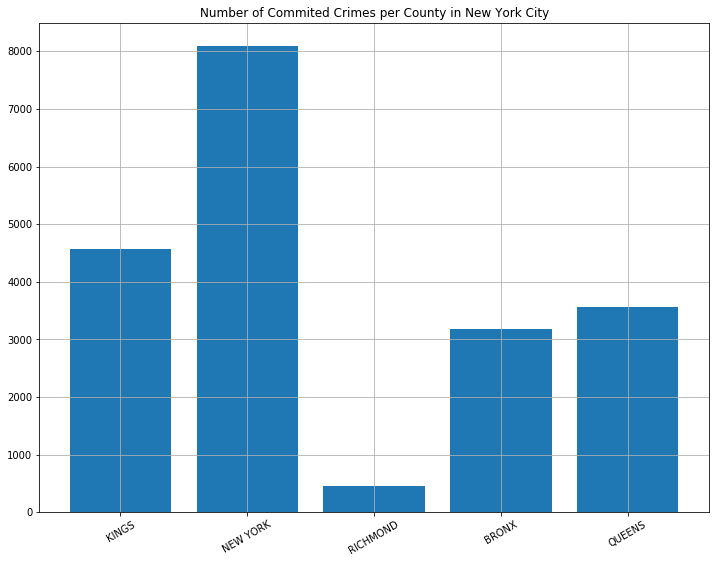

In [120]:
plt.figure(figsize=(12, 9))

counties = set(df['crime 1 - county of commitment'])
crimes_columns = list(filter(lambda x: 'county of commitment' in x, df.columns))
values = []
for county in counties:
    
    values.append(sum(list(map(lambda x: len(df[df[x] == county]),
                               crimes_columns))))

index = np.arange(len(counties))
plt.bar(index, values)
plt.grid(True)
plt.xticks(index, counties, fontsize=10, rotation=30)
plt.title('Number of Commited Crimes per County in New York City')

(0.0, 1.0, 0.0, 1.0)

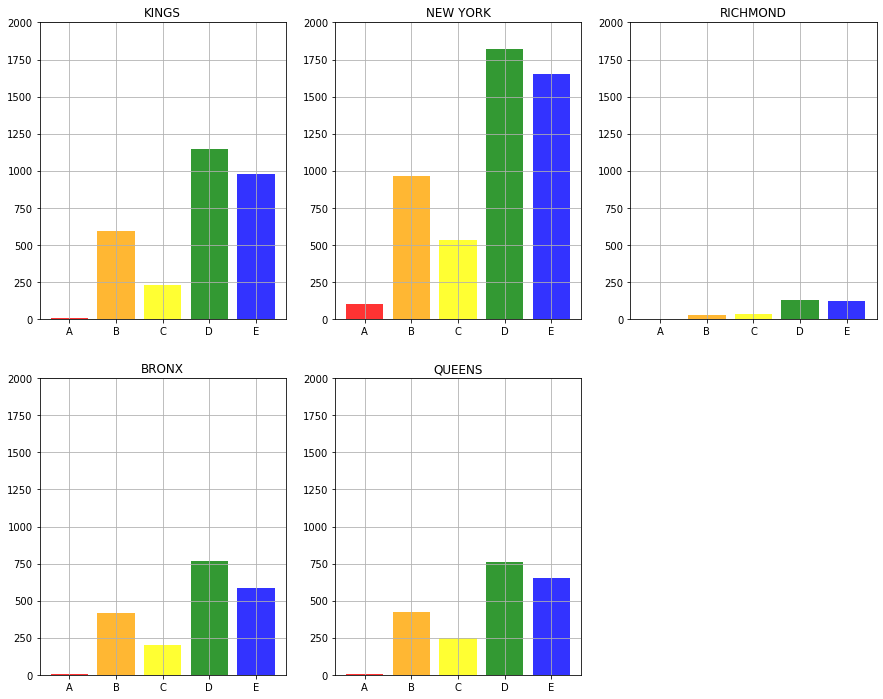

In [121]:
# run this before categorize the features
counties = set(df['crime 1 - county of commitment'])
crimes_columns = list(filter(lambda x: 'county of commitment' in x, df.columns))

counties_info = []
index = np.arange(len(set(df['crime 1 - class'])))

for county in counties:
    
    df_aux = df[df['crime 1 - county of commitment'] == county]
    county_crimes = count_instances(df_aux, 'crime 1 - class')
    county_crimes['County'] = county
    counties_info.append(county_crimes)


fig, axes = plt.subplots(figsize=(15,12),nrows=2, ncols=3)

columns = {0: [0,0], 1: [0,1], 2: [0,2], 3: [1,0], 4: [1, 1]}
colors = ['red', 'orange', 'yellow', 'green', 'blue']
# Transforming dict in dataframe

flag = True
for idx, county in enumerate(counties_info):
    county_name = county['County']

    values = list(county.values())
    keys = list(county.keys())

    keys, values = zip(*sorted(zip(keys, values)))
    keys, values = list(keys), list(values)
    values = list(filter(lambda x: county_name != x, values))
    keys = list(filter(lambda x: 'County' != x, keys))

    if flag:
        axes[columns[idx][0], columns[idx][1]].bar(index, values, color = colors, alpha = 0.8)
    else:
        axes[columns[idx][0], columns[idx][1]].bar(index, values,
                                                   color = colors, alpha = 0.8, sharex=axes[0, 0])
    #axes.set_ylim([ymin,ymax])
    axes[columns[idx][0], columns[idx][1]].title.set_text(county_name)
    axes[columns[idx][0], columns[idx][1]].grid(True)
    axes[columns[idx][0], columns[idx][1]].set_xticklabels([0] + keys)
    axes[columns[idx][0], columns[idx][1]].set_ylim(0, 2000) # was manually setted
    
axes[1][2].axis('off')

### Categorizing all variables

In [122]:
def categorize_related_features(df, category_string, categories):
    
    values = []
    columns = list(filter(lambda x: category_string in x, df.columns))
    for column in columns:
        values += list(set(df[column]))

    values = list(set(values))
    values = {values[i] : i for i in range(0, len(values))}

    categories.append({category_string: values})

    for column in columns:
        df[column] = df[column].replace(categories[-1][category_string])
    
    
    return df, columns, categories

In [123]:
# Essa categorização está incorreta, cada crime está com uma categoria diferente além disso, onde é cometido tbm 
categories, removed_columns = [], []
categorize_features = ['crime of conviction', 'county of commitment', 'housing', 'class']
for feature in categorize_features:
    df, columns, categories = categorize_related_features(df, feature, categories)
    removed_columns += columns


for column in df.columns:
    if column not in removed_columns and 'date' not in column:
        categories.append({column :dict(enumerate(df[column].astype('category').cat.categories))})
        df[column] = df[column].astype("category").cat.codes

### Auxiliary Function: Statistic  Validation

In [95]:
from sklearn.model_selection import cross_val_score
import numpy as np

def statistic_validation(x, y, model):
    
    scores = cross_val_score(model, x, y, scoring='f1_micro', cv=10)
    print(scores)
    print("Mean: ", statistics.mean(scores))
    print("Std. Deviation: ", statistics.stdev(scores))

    try:
        for feat, importance in zip(x.columns, model.feature_importances_):
            print(feat, importance)
    except:
        pass

### Auxiliary Function: Defining train and Test slipt

In [96]:
from sklearn.model_selection import train_test_split

def model_hold_out(x, y, model):

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

    model = model.fit(X_train, y_train)
    y_predicted  = model.predict(X_test)

    return model

### Auxiliary Function: Confusion Matrix

In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

def confusion_matrix_calc(x, y, model):

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

    model = model.fit(X_train, y_train)
    y_predicted  = model.predict(X_test)

    print(confusion_matrix(y_test, y_predicted))

### Auxiliary Function: Model Evaluation

In [98]:
from sklearn.utils import shuffle

def model_evaluation(df, model, columns = [], evaluate = True):

    df_copy = df.copy()


    y = df_copy['interview decision']
    x = df_copy.drop(['interview decision', 'release date',
                      'release type'] + commited_crimes + columns, axis = 1)

    x,y = shuffle(x, y)
    
    if evaluate:
        statistic_validation(x, y, model)
    
    return x, y

# Research Question: It is possible to predict the decision of the parole commisioner ?

Not very good, but it is possible

### Random Forest: All Features

In [126]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
x, y = model_evaluation(df, model)
confusion_matrix_calc(x, y, model)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.58648431 0.56798069 0.58132045 0.59516129 0.5811138  0.59369952
 0.57350565 0.59531502 0.57996769 0.60436893]
Mean:  0.5858917362405754
Std. Deviation:  0.011207549479418683
[[1644    5    1   47  294    0    0    0    0]
 [   5   16    0    2    5    0    0    0    0]
 [   9    0  244   56   17    0    0    0    0]
 [ 281    1  120  104   97    1    0    0    0]
 [ 425    2   45   93  187    1    0    1    0]
 [   6    0    1    3    0    0    0    0    0]
 [   1    0    0    0    1    0    0    0    0]
 [   3    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0]]


### Logistic Regression: All Features

In [127]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
x, y = model_evaluation(df, model)
confusion_matrix_calc(x, y, model)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.53177796 0.53016895 0.5273752  0.52903226 0.53026634 0.53150242
 0.53634895 0.53311793 0.53634895 0.53478964]
Mean:  0.5320728605096643
Std. Deviation:  0.0030488065718099915
[[1991    1    8    3    7    0    0    0]
 [  41    3    2    0    0    0    0    0]
 [ 320    0    0    0    0    0    0    0]
 [ 600    0    0    2    0    0    0    0]
 [ 699    1   19    0    4    0    0    0]
 [  13    0    0    0    0    0    0    0]
 [   1    0    1    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0]]


# RESEARCH QUESTIONS

### It is possible to predict the parole commissioner decision ?
It is possible. But the results achieved are very good due the lack of data. The dataset is very poluted.


### If I remove sensible features it is possible to achieve better results ? (i.e. how sensible features intefere in the decision

It is possible to achieve slight better results, it are not significant.

### What is the models behavior through different sensible features ? (race, gender and county)
It is the same. Initialy the dataset is desbalanced with most features denning the parole hearing. Thus, our results are very good. Should we use a oversampling technique or a undersampling ?

### Which features are most important to define the sentence of a criminal ?
This is done. We consider the most important features given by Random Forest model.

### What the correlation graph can tell about the features ?

### Joining different datasets, we can better understand the sentences ?
We can try to verify the resuilts achieved in one dataset in another.

### Where most crimes happen ? Are this related with some index of the other base ?
Done. New York is the county with most crimes and most violent crimes.


# Research Question:  If I remove sensible features it is possible to achieve better results ? (i.e. how sensible features intefere in the decision) ? What is the behavior of the algorithm without this features (is better ? is worse ?)


The algorithms get slight better when removing columns of where the crime where commited, but is not very significative. Removing sensible features it is possible to verify that it does not intefere in any of the models.

In [543]:
from IPython.display import HTML, display
import tabulate
table = [['Features', 'RandomForest', 'LogisticRegression'],
         ['With All Features', 0.583, 0.53],
         ['Without Race', 0.583, 0.531],
         ['Withou Sex', 0.587, 0.532],
         ['Without Crime County', 0.59, 0.53]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Features,RandomForest,LogisticRegression
With All Features,0.583,0.53
Without Race,0.583,0.531
Withou Sex,0.587,0.532
Without Crime County,0.59,0.53


### Removing Race

In [544]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
x, y = model_evaluation(df, model, ['race / ethnicity'])
confusion_matrix_calc(x, y, model)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.53499598 0.52855994 0.53059581 0.52903226 0.53349475 0.53392569
 0.53392569 0.53634895 0.52988691 0.53398058]
Mean:  0.5324746558220275
Std. Deviation:  0.002713918961910198
[[1990    1    9    1   17    0    0    0    0]
 [  29   10    2    0    0    0    0    0    0]
 [ 315    0    1    0    0    0    0    0    0]
 [ 612    0    2    2    0    0    0    0    0]
 [ 692    1   14    2    4    0    0    0    0]
 [   8    0    0    0    0    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0]
 [   5    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0]]


In [545]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
x, y = model_evaluation(df, model, ['race / ethnicity'])
confusion_matrix_calc(x, y, model)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.58809332 0.58004827 0.57004831 0.57741935 0.59402744 0.58077544
 0.58966074 0.56865913 0.58885299 0.55744337]
Mean:  0.579502836783434
Std. Deviation:  0.01142716694890212
[[1685    3    2   69  272    0    0    0]
 [   8   21    0    4    4    0    0    0]
 [  26    0  220   63   22    0    0    0]
 [ 274    1   94  114   97    2    0    0]
 [ 423    2   35   81  182    1    1    0]
 [   5    0    3    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    2    2    0    0    0]]


### Removing Sex

In [546]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
x, y = model_evaluation(df, model, ['sex'])
confusion_matrix_calc(x, y, model)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.53258246 0.53499598 0.52898551 0.53629032 0.53026634 0.53392569
 0.53069467 0.53231018 0.53069467 0.53398058]
Mean:  0.5324726397375426
Std. Deviation:  0.002326557372011988
[[1951    1    6    1    9    0    0    0    1]
 [  30    6    1    0    1    0    0    0    0]
 [ 314    0    0    0    0    0    0    0    0]
 [ 644    1    0    0    0    0    0    0    0]
 [ 711    2    8    0   10    0    1    0    0]
 [  11    0    0    0    0    0    0    0    0]
 [   2    0    1    0    0    0    0    0    0]
 [   5    0    0    0    0    0    0    0    0]
 [   2    0    0    0    0    0    0    0    0]]


In [547]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
x, y = model_evaluation(df, model, ['sex'])
confusion_matrix_calc(x, y, model)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.58567981 0.58326629 0.58534622 0.57983871 0.58757062 0.58966074
 0.58562197 0.58481422 0.58966074 0.56148867]
Mean:  0.5832947991883346
Std. Deviation:  0.008194893874872756
[[1638    5    0   57  278    0    0    0]
 [  13   19    0    1    7    0    0    0]
 [   9    0  242   54   24    0    0    0]
 [ 284    0  100  114  108    1    0    0]
 [ 413    2   42   93  193    0    0    0]
 [   5    0    3    4    2    0    0    0]
 [   0    0    0    0    2    0    0    0]
 [   2    0    0    0    4    0    0    0]]


### Removing County of Commited Crime

In [128]:
county_crimes = list(filter(lambda x: 'county of commitment' in x, df.columns))

In [549]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
x, y = model_evaluation(df, model, county_crimes)
confusion_matrix_calc(x, y, model)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.52936444 0.52614642 0.53462158 0.53225806 0.53753027 0.53311793
 0.53069467 0.53392569 0.5355412  0.53398058]
Mean:  0.5327180835341817
Std. Deviation:  0.0032779049833613163
[[1917    3    6    0   21    0    0    0]
 [  35    7    0    0    0    0    0    0]
 [ 346    0    0    0    0    0    0    0]
 [ 620    3    1    0    4    0    0    0]
 [ 716    1    6    0   13    0    0    0]
 [  11    0    0    0    0    0    0    0]
 [   7    0    0    0    0    0    0    0]
 [   2    0    0    0    0    0    0    0]]


In [550]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
x, y = model_evaluation(df, model, county_crimes)
confusion_matrix_calc(x, y, model)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.59372486 0.58728882 0.5821256  0.60322581 0.60613398 0.59612278
 0.58239095 0.59369952 0.57512116 0.58171521]
Mean:  0.5901548686615824
Std. Deviation:  0.010095700654977117
[[1603    2    1   55  272    0    0    0    0]
 [  17   16    0    0    5    0    0    0    0]
 [   5    0  261   64   25    0    0    0    0]
 [ 275    0  104  124   90    1    0    0    0]
 [ 425    1   44  106  198    1    2    1    0]
 [   5    0    4    5    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   2    0    0    1    1    0    0    0    0]
 [   1    0    0    1    0    0    0    0    0]]


# Research Question: What is the models behavior through different sensible features ? (race, gender and county) 

In theory will not intefere much in the results.
- In this evaluation we will vary: Race, Gender and County
- Gender:
    - MALE
    - FEMALE
- Race:
    - AMER IND/ALSK
    - ASIAN/PACIFIC
    - BLACK
    - HISPANIC
    - OHTER
    - UNKNOWN
    - WHITE
- County:
    - KINGS
	- QUEENS
	- NEW YORK
	- BRONX
	- RICHMOND

In [151]:
def model_instance_variation(df, model, categories):
    
    evaluted_columns = ['sex', 'race / ethnicity', 'county of commitment', 'interview decision']
    values = {}
    for category in categories:
        key = list(category.keys())[0]
        if key in evaluted_columns:
            values[key] = category[key]

    # I will evaluate with some different features, with different commited crimes - I will range the crime class

    instance = df[df['interview decision'] == 1].iloc[0] # Original instance

    instance = df.iloc[0]
    instance.drop(['interview decision', 'release date',
                   'release type'] + commited_crimes, inplace=True)
    print(values['interview decision'])
    original_instance = instance.copy()
    
    for sex in values['sex'].keys():
        instance['sex'] = sex
        for race in values['race / ethnicity'].keys():
            instance['race / ethnicity'] = race
            for crime in values['county of commitment'].keys():
                instance['crime 1 - county of commitment'] = values['county of commitment'][crime]
                print("Parameters: ")
                print("Crime 1: ", crime)
                print("Race: ", values['race / ethnicity'][race])
                print("Sex: ", values['sex'][sex])
                #print(instance)
                instance = instance.values.reshape(-1, 34)
                print(values['interview decision'][model.predict(instance)[0]])
                instance = original_instance.copy()

### RANDOM FOREST: EVALUATING COMBINATIONS

In [152]:
model = RandomForestClassifier()
x, y = model_evaluation(df, model, [], False)
model = model_hold_out(x, y, model)
model_instance_variation(df, model, categories)

/usr/lib/python3.7/site-packages/pandas/core/generic.py:3114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(obj)
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


{0: 'DENIED', 1: 'GRANTED', 2: 'NOT GRANTD', 3: 'OPEN DATE', 4: 'OR EARLIER', 5: 'PAROLED', 6: 'RCND&HOLD;', 7: 'RCND&RELSE;', 8: 'REINSTATE'}
Parameters: 
Crime 1:  CHEMUNG
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  WYOMING
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  MONTEREY
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  SCHENECTADY
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  Mar-00
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  BROOME
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  SENECA
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ST LAWRENCE
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ROCKLAND
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ALBANY
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  DUTCHESS
Race:  AMER IND/ALSK
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  COLUMBIA
Race:  AMER IND/ALSK
Sex: 

DENIED
Parameters: 
Crime 1:  WASHINGTON
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  CHAUTAUQUA
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ONEIDA
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  4/14/15
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  FRANKLIN
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  BRONX
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ORLEANS
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  SULLIVAN
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  SUFFOLK
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  GREENE
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ULSTER
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  Apr-00
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  NEW YORK
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  RICHMOND
Race:  HISPANIC
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  JEFFERSON
Race:  HISPANIC
Se

Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  4/14/15
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  FRANKLIN
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  BRONX
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ORLEANS
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  SULLIVAN
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  SUFFOLK
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  GREENE
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ULSTER
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  Apr-00
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  NEW YORK
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  RICHMOND
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  JEFFERSON
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  ONONDAGA
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  NOT FOUND
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Crime 1:  CLINTON
Race:  WHITE
Sex:  FEMALE
DENIED
Parameters: 
Cri

DENIED
Parameters: 
Crime 1:  NEW YORK
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  RICHMOND
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  JEFFERSON
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  ONONDAGA
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  NOT FOUND
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  CLINTON
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  WESTCHESTER
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  ERIE
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  LIVINGSTON
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  MIDSTATE
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  QUEENS
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  ORANGE
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  KINGS
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  CAYUGA
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  NASSAU
Race:  BLACK
Sex:  MALE
DENIED
Parameters: 
Crime 1:  SARATOGA
Race:  BLACK
Sex:  MALE
D

DENIED
Parameters: 
Crime 1:  CAYUGA
Race:  UNKNOWN
Sex:  MALE
DENIED
Parameters: 
Crime 1:  NASSAU
Race:  UNKNOWN
Sex:  MALE
DENIED
Parameters: 
Crime 1:  SARATOGA
Race:  UNKNOWN
Sex:  MALE
DENIED
Parameters: 
Crime 1:  Not Commited
Race:  UNKNOWN
Sex:  MALE
DENIED
Parameters: 
Crime 1:  OTSEGO
Race:  UNKNOWN
Sex:  MALE
DENIED
Parameters: 
Crime 1:  CHEMUNG
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  WYOMING
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  MONTEREY
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  SCHENECTADY
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  Mar-00
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  BROOME
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  SENECA
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  ST LAWRENCE
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  ROCKLAND
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  ALBANY
Race:  WHITE
Sex:  MALE
DENIED
Parameters: 
Crime 1:  DUTCHESS
Race:  WHITE

### LOGISTIC REGRESSION: EVALUATING COMBINANTIONS

In [553]:
model = LogisticRegression()
x, y = model_evaluation(df, model, [], False)
model = model_hold_out(x, y, model)
model_instance_variation(df, model, categories)

Parameters: 
Crime 1:  105
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  80
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  107
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  86
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  92
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  5
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  6
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  7
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  77
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  78
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  79
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  11
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  81
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  83
Race:  AMER IND/ALSK
Sex:  FEMALE
[0]
DENIED
Paramet

Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  105
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  80
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  107
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  86
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  92
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  5
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  6
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  7
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  77
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  78
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  79
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  11
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  81
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  83
Race:  HISPANIC
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  84
Race:  HISPANIC
Sex:  FEMAL

Crime 1:  50
Race:  WHITE
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  58
Race:  WHITE
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  70
Race:  WHITE
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  82
Race:  WHITE
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  89
Race:  WHITE
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  93
Race:  WHITE
Sex:  FEMALE
[0]
DENIED
Parameters: 
Crime 1:  105
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  80
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  107
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  86
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  92
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  5
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  6
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  7
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  77
Race:  AMER IND/ALSK
Sex:  MALE
[0]
DENIED
Parameters: 
Cr

Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  69
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  73
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  72
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  109
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  108
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  50
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  58
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  70
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  82
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  89
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  93
Race:  HISPANIC
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  105
Race:  OTHER
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  80
Race:  OTHER
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  107
Race:  OTHER
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  86
Race:  OTHER
Sex:  MALE
[0]
DENIED
Parameters: 
Crime 1:  92


In [153]:
count_instances(df, 'interview decision')

{0: 6629, 1: 133, 2: 1105, 3: 2010, 4: 2460, 5: 39, 6: 4, 7: 12, 8: 3}

### Next Chapter Scenes: